# Step 1 Pre-Process Data

In [71]:
import numpy as np
from pathlib import Path
from skimage.io import imread
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import cv2
import imgaug.augmenters as iaa

from tensorflow.keras.utils import to_categorical

In [2]:
# This is not in the repo because it is too big.
# Download it from the kaggle site and keep it in the repo.
data_dir = Path('sacm2021')

train = data_dir / 'TrainImages/TrainImages'
test = data_dir / 'TestImages/TestImages'


train_images = train.glob('*.png')
test_images = train.glob('*.png')


# Store a link to the image and the id together in a list
# Will turn into a dataframe later
# Image label is the numeric part of the image file name
# Will extract that using some ~~~string magic~~~
training_data_and_id = []

for img in train_images:
    
    image_id = (
        str(img).
        replace(str(train), '').
        replace('.png', '').
        replace('/','') 
    )
    
    image_id = int(image_id)
    
    training_data_and_id.append((img, image_id))
    

In [3]:
image_frame = pd.DataFrame(training_data_and_id, columns = ['img','id'])
labels = pd.read_csv('sacm2021/train.csv')

# Combine the labels and the image locations into a single frame
df = image_frame.merge(labels)

print(df.head())

                                        img   id  classification
0  sacm2021/TrainImages/TrainImages/345.png  345               2
1  sacm2021/TrainImages/TrainImages/257.png  257               2
2  sacm2021/TrainImages/TrainImages/265.png  265               1
3  sacm2021/TrainImages/TrainImages/724.png  724               1
4  sacm2021/TrainImages/TrainImages/198.png  198               3


In [4]:
# Fairly even but not completely even
df.classification.value_counts(normalize=True).round(2)

2    0.35
0    0.23
1    0.22
3    0.21
Name: classification, dtype: float64

(956, 1024, 3)
(883, 1024, 3)
(840, 1024, 3)
(1024, 966, 3)
(851, 1024, 3)
(851, 1024, 3)
(970, 1024, 3)
(840, 1024, 3)
(1024, 840, 3)
738


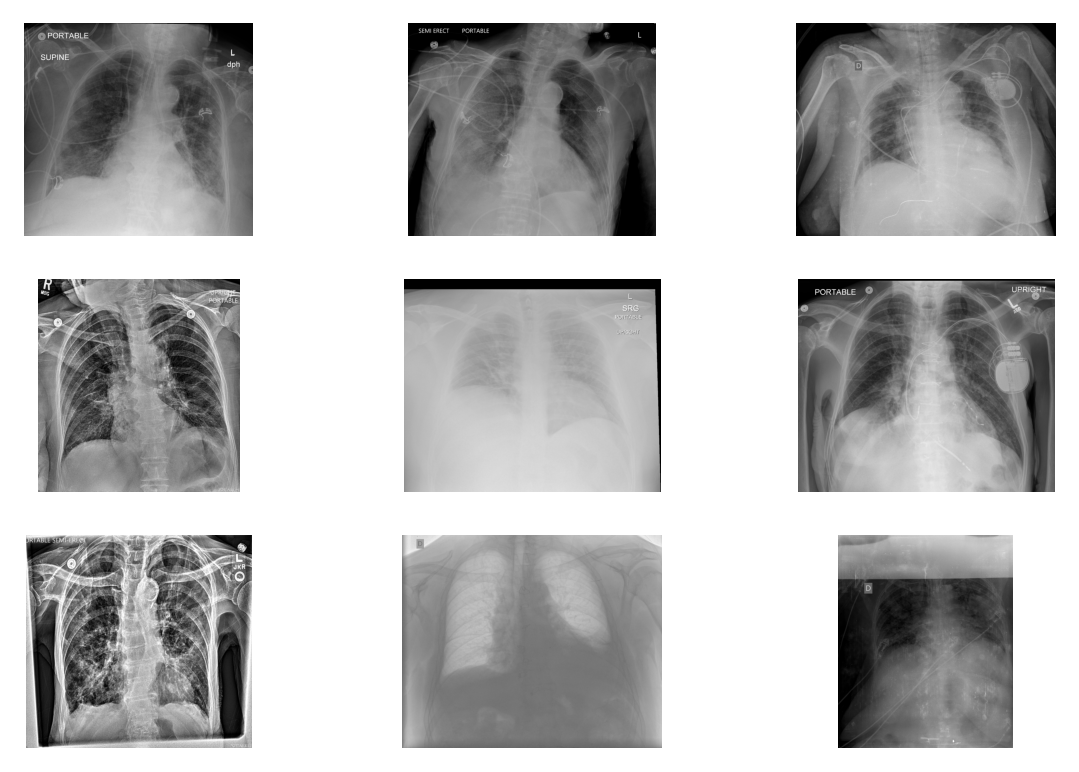

In [15]:
# What do a few of these look like?
fig, ax = plt.subplots(dpi = 240, nrows = 3, ncols = 3)
ax = ax.ravel()

xd = []

for img, axis in zip(df.sample(9).img.tolist(), ax):
    xray = imread(img)
    print(xray.shape)
    axis.imshow(xray)
    axis.axis('off')
    
# Figure out the minimum X dimension (*SLOW*, feel free to remove)
dims = [imread(str(df.iloc[i,0])).shape[0] for i in range(df.shape[0])]
#print(pd.Series(dims).value_counts())
print(np.min(dims))

In [6]:
# Prepare training and test sets 
train, test = train_test_split(df, test_size=0.3, random_state=0)

print(train.shape)
print(test.shape)

print(type(train))
print(train.head())
print(test.head())

(668, 3)
(287, 3)
<class 'pandas.core.frame.DataFrame'>
                                          img   id  classification
71   sacm2021/TrainImages/TrainImages/294.png  294               0
49   sacm2021/TrainImages/TrainImages/723.png  723               0
483  sacm2021/TrainImages/TrainImages/515.png  515               2
362  sacm2021/TrainImages/TrainImages/683.png  683               1
294  sacm2021/TrainImages/TrainImages/793.png  793               1
                                          img   id  classification
877  sacm2021/TrainImages/TrainImages/480.png  480               3
901  sacm2021/TrainImages/TrainImages/547.png  547               3
14    sacm2021/TrainImages/TrainImages/32.png   32               2
703  sacm2021/TrainImages/TrainImages/595.png  595               2
55   sacm2021/TrainImages/TrainImages/782.png  782               3


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


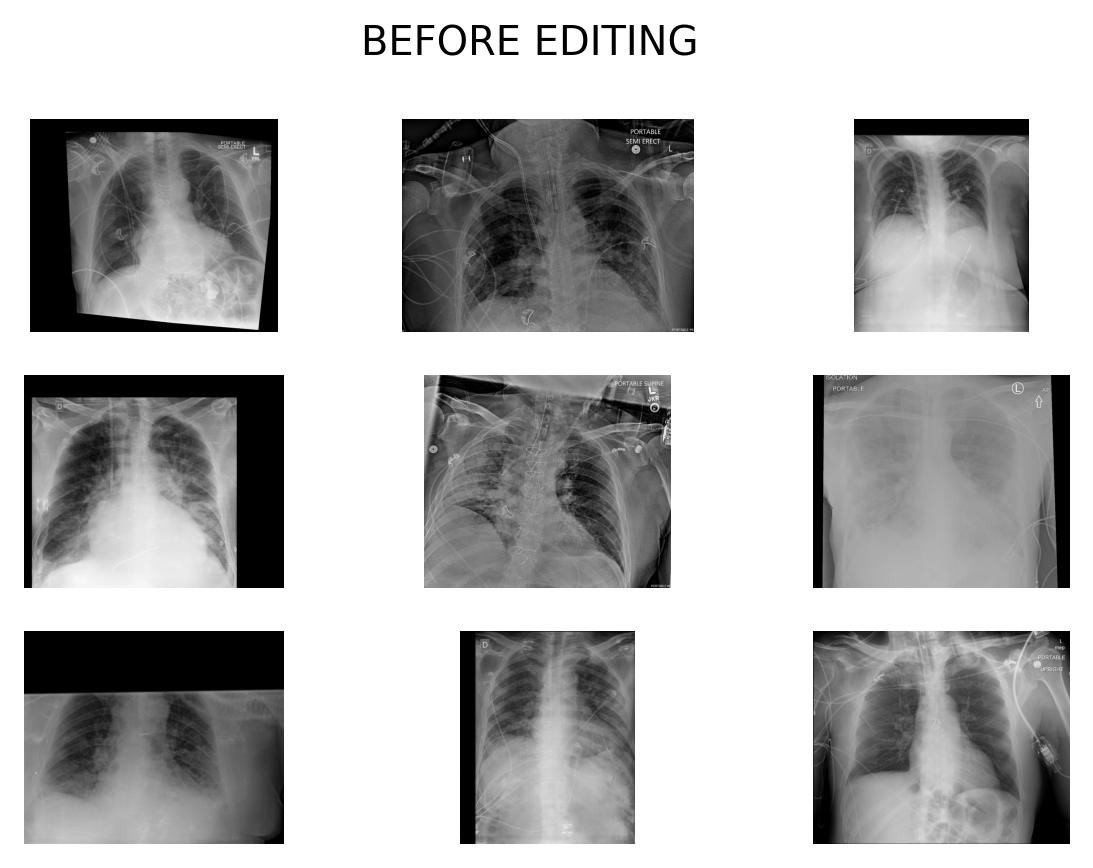

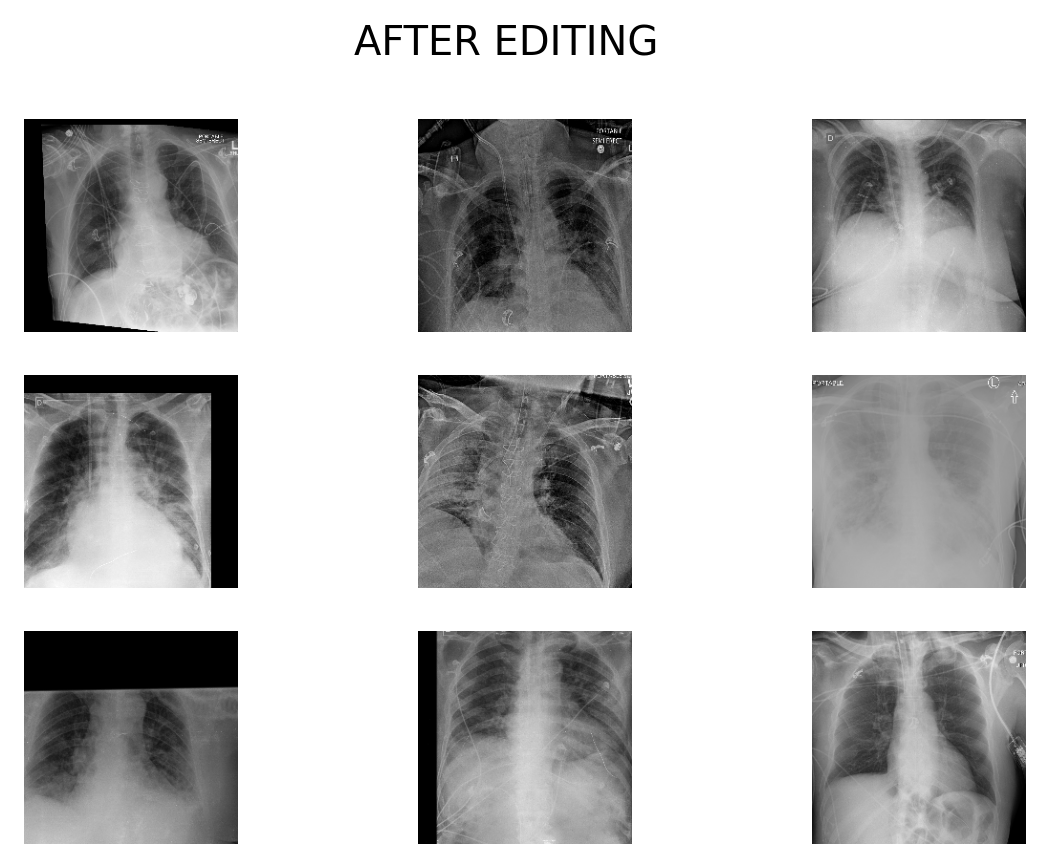

In [69]:
# Resizes the image to a square of size DIMxDIM
# Symmetrically crops x_trim % off the left/right ... same for y
def resizeCrop(img, square_dim=224, x_trim=0.075, y_trim=0.075):
    image = cv2.imread(str(img))
    
    # Trimming x and y based on size
    dim = image.shape
    
    x_scale = x_trim * ((dim[1] - 840)/ (1024-840)) # given dimensions,
    y_scale = y_trim * ((dim[0] - 738) / (1024-738)) # crop an appropriate amount (up to 10%)
    
    cut_y = int(np.round(dim[0]*y_scale))
    cut_x = int(np.round(dim[1]*x_scale))
    
    # Trim x and y 
    image = image[cut_y:dim[0]-cut_y,cut_x:dim[1]-cut_x]
    
    # Resize image 
    image = cv2.resize(image, (square_dim,square_dim))

    return(image)



# Plot before editing
fig, ax = plt.subplots(dpi = 240, nrows = 3, ncols = 3)
fig.suptitle('BEFORE EDITING')
ax = ax.ravel()

sample = train.iloc[:,0].sample(9)
print(type(sample))
for img, axis in zip(sample, ax):
    xray = imread(img)
    axis.imshow(xray)
    axis.axis('off')

sample = pd.Series([resizeCrop(x) for x in sample])
print(type(sample))  
# Plot after editing

fig, ax = plt.subplots(dpi = 240, nrows = 3, ncols = 3 )
fig.suptitle('AFTER EDITING')
ax = ax.ravel()

for img, axis in zip(sample, ax):
    #xray = imread(img)
    axis.imshow(img)
    axis.axis('off')  
    



In [70]:
# Preprocess the test/validation set 
test_img = []
test_lab = []

for i in range(test.shape[0]):
    test_img.append(resizeCrop(str(test.iloc[i,0])))
    test_lab.append(to_categorical(test.iloc[i,2], num_classes=4))
    
test_img = np.array(test_img)
test_lab = np.array(test_lab)

print(test_img.shape)
print(test_lab.shape)

(287, 224, 224, 3)
(287, 4)


In [ ]:
def data_generator(img_paths, labels, batch_size):
    
    num_samples = len(img_paths)
    steps = num_samples//batch_size # // is equivalent to np.floor(x/y)
    
    batch_data = np.zeros((batch_size, 244, 244, 3), dtype = np.float32)
    batch_labels = np.zeros((batch_size, 2), dtype = np.float32)
    
    indicies = np.arange(num_samples)
    
    i=0
    while True:
        
        np.random.shuffle(indicies) # shuffles in place, no need to assign to a new variable
        
        count = 0
        
        next_batch = indicies[(i*batch_size):(i+1)*batch_size]
        
        for j, idx in enumerate(next_batch):
            
            img_name = img_paths[idx]
            label = labels[idx]
            
            encoded_label = to_categorical(label, num_classes=4)
            
            img = resizeCrop(img_name)
            #orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32)/255.0
            
            # Augment the image
            batch_data[count] = seq.augment_image(img)
            batch_labels[count] = encoded_label
            
        i+=1
        
        yield batch_data, batch_labels
        
        if i>steps:
            i = 0
            